## Python notebook version of generate_sample_U.py

In [129]:
'''
Generate set S of sensor placements and set U of locations which we are interested in but cannot place a sensor.
    S : Dataframe of network sensor locations
    U : Dataframe of uniformally distributed placements in the LAQN in raw latitude longitdue coordinates.
'''
from turtle import title
import pandas as pd
import math
import json
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np
import random
from shapely.geometry import shape, GeometryCollection, Point, Polygon, MultiPolygon, LinearRing
import geopandas
from shapely.geometry.polygon import Polygon
# from shapely.geometry import Polygon, Point

In [232]:
def generate_placement_sets(n=10000, plot=False):
    '''
    param n : int : the number of placements of interest in set U
    returns : (pd.DataFrame, pd.DataFrame) : tuple of sets in order (S, U)
    '''
    header_list = ["SiteCode", "Latitude", "Longitude"]
    sensor_coords_df = pd.read_csv("../data-collection/LAQN_API_data/site_coordinates.csv", names=header_list)

    S_df = generate_set_S(sensor_coords_df, plot=False)
    U_df = generate_set_U(sensor_coords_df, n, plot)

    return S_df, U_df

In [233]:
def generate_set_S(sensor_coords_df, plot=False):
    
    ## site placements in original coordinates 
    set_S = sensor_coords_df.loc[:, sensor_coords_df.columns.drop(["SiteCode"])]
    if plot:
        set_S.plot(x="Longitude", y="Latitude", kind="scatter",
            title="Set S: Sensor Placements")
        plt.show()

    ## site placements in normalized coordinate locations
    # set_S = normalize(coordinates_df=sensor_coords_df)
    # set_S.plot(x="NormalizedX", y="NormalizedY", kind="scatter",
    #     colormap="YlOrRd")
    # plt.show()

    return set_S

In [240]:
def generate_set_U(sensor_coords_df, n, plot=False):
    '''
    Given a dataframe of all sensor coordinates and integer n, returns dataframe of n U placements that are 
    uniformly distributed within the London boundaries. These placements do not overlap with sensor coordinates.
    '''
    ## retrieve London coordinate boundaries
    london_burough_boundaries_df = get_london_boundaries()
    london_gdf = geopandas.GeoDataFrame(
        london_burough_boundaries_df, geometry=geopandas.points_from_xy(london_burough_boundaries_df.Longitude, london_burough_boundaries_df.Latitude))
    
    ## find max and min latitude and longitude coordinates, extremes
    min_latitude = math.floor(london_burough_boundaries_df.Latitude.min())
    max_latitude = math.ceil(london_burough_boundaries_df.Latitude.max())
    
    min_longitude = math.floor(london_burough_boundaries_df.Longitude.min())
    max_longitude = math.ceil(london_burough_boundaries_df.Longitude.max())
    
    ## produce equally distributed values of latitude and longitude coordinates within London max and min boundaries
    latitudes = np.linspace(min_latitude, max_latitude, int(n**0.5))
    longitudes =  np.linspace(min_longitude, max_longitude, int(n**0.5))
    u_sites = {'code': [], 'Latitude': [], 'Longitude': []}
    
    ## creates map_df that contains shapely polygons for each burough
    fp = "../data-collection/london_boroughs.json"
    map_df = geopandas.read_file(fp).to_crs("EPSG:4326")
    map_df = map_df.explode(index_parts=False)

    ## creates U locations with corresponding code
    for i in range(int(n**0.5)):
        for j in range(int(n**0.5)):
            site_code = f"U_{i*j}" # U location code
            num_decimal_places = 13
            float_long = round(float(longitudes[i]), num_decimal_places)
            float_lat = round(float(latitudes[j]), num_decimal_places)
            
            ## creates Point instance of coordinate and a bounding polygon that contains the point
            coord = Point(float_long, float_lat)
            poly_point = Polygon([(coord.x + lam_lat, coord.y + lam_lon) for lam_lat in p_range for lam_lon in p_range])
            
            ## finds whether the bounding coordinate polygon intersects with the burough boundaries
            for burough in map_df.geometry:
                if burough.intersects(poly_point):                   
                    u_sites['code'].append(site_code)
                    u_sites['Latitude'].append(latitudes[j])
                    u_sites['Longitude'].append(longitudes[i])

    u_sites_df = pd.DataFrame(u_sites)
    
    ## removes current sensor locations from uniformly coordinate placements
    intersection_locations = pd.merge(u_sites_df, sensor_coords_df, how='inner', on=['Latitude', 'Longitude'])
    set_U = pd.concat([u_sites_df, intersection_locations]).drop_duplicates(keep=False)

    ## plot london boundaries and selected locations of set U
    if plot:
        map_df.plot()
        plt.show()

        set_U.plot(x="Longitude", y="Latitude", title="Set U", kind="scatter")
        plt.show()

    return set_U

In [235]:
def normalize(coordinates_df):
    '''
    given dataframe of coordinates in latitude and longitude, returns a dataframe of sensor locations
    with normalized coordinates to area of interest

    param coordinates_df : pd.DataFrame : sensor locations with the following column: SiteCode, Latitude, Longitude
        - Site Code Format: {A-Z}{A-Z}{0-9}, Example: “TD0”

    returns : pd.DataFrame : dataframe including sensor locatiosn in format: SiteCode, X, Y
    '''
    normalized_coords_df = pd.DataFrame(columns=["SiteCode", "NormalizedX", "NormalizedY"])
   
    min_longitude = coordinates_df.Longitude.min()
    max_longitude = coordinates_df.Longitude.max()
    delta_longitude = max_longitude - min_longitude

    min_latitude = coordinates_df.Latitude.min()
    max_latitude = coordinates_df.Latitude.max()
    delta_latitude = max_latitude - min_latitude
    
    for index, row in coordinates_df.iterrows():
        norm_x = (row.Longitude - min_longitude) / delta_longitude
        norm_y = (row.Latitude - min_latitude) / delta_latitude 
        normalized_dict = {"SiteCode": row.SiteCode, "NormalizedX": norm_x, "NormalizedY": norm_y}
        normalized_coords_df = normalized_coords_df.append(normalized_dict, ignore_index = True)

    return normalized_coords_df

In [236]:
def get_london_boundaries():
    '''
    Returns dataframe of all burough boundaries with columns [latitude, longitude]
    '''
    # if PyShp shapefile library is installed, can read shapefile
    # shape = shapefile.Reader("code/data-collection/London_Borough_Excluding_MHW.shp")

    boundaries = []

    london_burough_boundaries = json.load(open("../data-collection/london_boroughs.json", ))
    for burough in london_burough_boundaries["features"]:
        for coordinate in burough["geometry"]["coordinates"][0][0]:
            boundaries.append(coordinate)
    
    london_burough_boundaries_df = pd.DataFrame(boundaries, columns=['Longitude', 'Latitude'])
    london_burough_boundaries_df = london_burough_boundaries_df[london_burough_boundaries_df.columns[::-1]]

    np_burough_boundaries = london_burough_boundaries_df.to_numpy()
    london_edges = alpha_shape(np_burough_boundaries, 0.25)
    
    # plt.figure()
    # plt.axis('equal')
    # plt.plot(np_burough_boundaries[:, 1], np_burough_boundaries[:, 0], '.')
    # for i, j in london_edges:
    #     plt.plot(np_burough_boundaries[[i, j], 1], np_burough_boundaries[[i, j], 0])
    # plt.show()

    return london_burough_boundaries_df


In [237]:
'''
Function retrieved from https://stackoverflow.com/questions/50549128/boundary-enclosing-a-given-set-of-points 
'''
def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

N =  5000


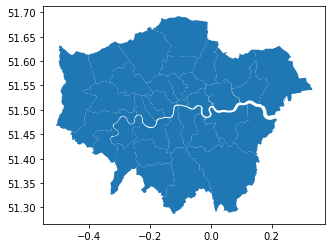

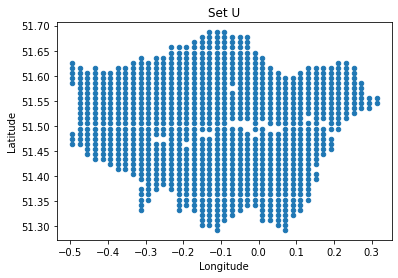

In [239]:
n = 10000
S_df, U_df = generate_placement_sets(n=n, plot=True)
